<a href="https://colab.research.google.com/github/Ajjme/Climate_Response_Modeling/blob/main/Earth_Heat_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Two layer heat energy model for the earth

## https://en.wikipedia.org/wiki/Idealized_greenhouse_model
## https://en.wikipedia.org/wiki/Heat_transfer_coefficient
## https://www.engineersedge.com/thermodynamics/overall_heat_transfer-table.htm
## https://enghandbook.com/thermodynamics/heat-transfer/


In [7]:
# this is the ODE4u function
def ode4u(odefun, time, x0, u=None, c=None):
    """
    Solve a system of nonhomogeneous ODEs using the 4th-order Runge-Kutta method.
    (it depends on not just time and state but also external inputs (u) and constanstant (c))

    Parameters:
        odefun : function (t, x, u, c) -> (dxdt, y)
                 returns state derivative and output as arrays
        time   : time values at which the solution is computed.
                 p-dimensional array
        x0     : n-dimensional array, state at time[0].
        u      : (m x p) dimensional array
                 optional input sampled at each time step.
        c      : optional constants passed to odefun.

    Returns:
        time   : ndarray, shape (1, p)
        x_sol  : ndarray, shape (n, p)
        x_drv  : ndarray, shape (n, p)
        y_sol  : ndarray, shape (m, p)
    """

    time   = np.asarray(time)
    x0     = np.asarray(x0).flatten()
    points = len(time) # the total number of time steps

    # create defaults if not provided
    if c is None:
        c = 0
    if u is None:
        u = np.zeros((1, points))
    else:
        u = np.asarray(u)

    # verify inputs recieved are in 2D array shape
    if u.ndim == 1:
        u = u[np.newaxis, :]

    if u.shape[1] < points:
        pad_width = points - u.shape[1]
        u = np.pad(u, ((0, 0), (0, pad_width)), mode='constant')

    # state derivitives and outputs at time[0]
    dxdt0, y0 = odefun(time[0], x0, u[:, 0], c)

    n = x0.size                 # number of states
    m = np.asarray(y0).size     # nuber of outputs

    # allocate memory
    x_sol = np.ones([n, points])*np.nan
    x_drv = np.ones([n, points])*np.nan
    y_sol = np.ones([m, points])*np.nan

    x_sol[:, 0] = x0    # states
    x_drv[:, 0] = dxdt0 # state derivitives
    y_sol[:, 0] = y0    # outputs

    for p in range(points - 1):  # time stepping loop and main integration
        t = time[p]
        dt = time[p + 1] - t
        dt2 = dt / 2.0

        u_mid = (u[:, p] + u[:, p + 1]) / 2.0

        # intermediate dervitives
        dxdt1, _ = odefun(t + dt2, x0 + dxdt0 * dt2, u_mid, c)
        dxdt2, _ = odefun(t + dt2, x0 + dxdt1 * dt2, u_mid, c)
        dxdt3, _ = odefun(t + dt,  x0 + dxdt2 * dt, u[:, p + 1], c)

        # state update using the intermediate derivities
        x0 = x0 + ( dxdt0 + 2 * (dxdt1 + dxdt2) + dxdt3 ) * dt / 6.0

        # state derivitives and outputs at start of time (p+1)
        dxdt0, y0 = odefun(time[p + 1], x0, u[:, p + 1], c)

        # save states (solution), state derivitives, and outputs
        x_sol[:, p+1] = x0    # state
        x_drv[:, p+1] = dxdt1 # state derivitives
        y_sol[:, p+1] = y0    # output

        # safety - incase NaN or Inf
#       if not np.all(np.abs(x0) > 1e12):
        if not np.all(np.isfinite(x0)):
            break

    return time, x_sol, x_drv, y_sol

In [8]:
#!/usr/bin/env python3


''' ... in console ...
import importlib , earth_heat_2
importlib.reload(earth_heat_2)
'''

import numpy as np
import matplotlib.pyplot as plt
#import ode4u as m
#import multivarious as m

# constants
# ---------
class c:
    pi  = np.pi
    c   =  299.792458e6       # speed of light  m/s
    h   =    6.62607015e-34   # Planck's constant  J/Hz
    k   =    1.380649e-23     # Boltzmann's constant J/deg K
    sbc =    5.670367e-8;     # Stefan-Boltzman constant  ... W/sq.m/deg K^4
    Rs  =    6.9570e08        # radius of sun, m
    D   =    1.4960e11        # sun - to - earth distance, m
    Re  =    6.3567523e6      # radius of earth, m
    Ts  = 5777                # sun temperature, K
    aa  =    0.30             # earth albedo 0.3 to 0.4 of solar reflected
    ee  =    0.78             # emissivity without GHG: 0.78  with GHG: 0.80
    sec_per_yr = 365*24*3600  # seconds per year
    years = 350               # years in the simulation
    lambda_LW = 4/3    # ??   # climate feedback parameter W/(K sq.m)
    RF = 4.00          # ??   # radiative forcing imbalance  W/sq.m
    atm_density_s = 1.23      # density of air at sea level kg/cu.m
    atm_density_t = 0.32      # density of air at top of troposphere kg/cu.m
    atm_depth = 13e3          # depth of troposphere m
    atm_water_cont= 0.004     # volume fraction of water in troposhere
    atm_shc = 1003            # specific heat capacity of air J/(kg K)
    atm_ocn_heat_transfer=5.001#??# atm-ocn heat transfer ?? 5 to 20 W/(sq.m K)
    ocn_depth = 2500   # ??   # depth of ocean m
    ocn_density = 1023.6      # density of seawater kg/cu.m
    ocn_shc = 4005            # specific heat capacity ocean water J/(kg K)

# computed constants
# ------------------
# solar constant W/sq.m  ...
    solar_const = sbc*Ts**4 * 4*pi*Rs**2 / (4*pi*D**2)
# ocean heat capacity per sq.m J/(sq.m K) ...
    ocn_J_m2K = ocn_shc * ocn_density * ocn_depth
# troposphere heat capacity per sq.m J/(sq.m K) ...
    atm_J_m2K = ocn_shc * ocn_density * 50.0 # 50 m of water in 13000 m of atm
    atm_J_m2K = atm_shc*0.5*(atm_density_s + atm_density_t)*atm_depth

# define the dynamical system in terms of a set of o.d.e's
# --------------------------------------------------------
def sys(t, x, u, c):
    """
    compute the state derivives dxdt at any point in time, for any state, and inpug.
    x = [ Q_atm , Q_ocn ]   states  ... heat in atmosphere and surface   J/sq.m
    """
# extract states from the vector of states , J/sq.m
    Q_atm = x[0]
    Q_ocn = x[1]

    T_atm = Q_atm / c.atm_J_m2K      # atmosphere deg K
    T_ocn = Q_ocn / c.ocn_J_m2K      #   ocean    deg K

# radiated heat from ocean, GHG, to space and convection from atm to ocn W/sq.m
# ... Atmosphere
    dQ_atm_dt = c.sbc*T_ocn**4 - (1-c.ee)*c.sbc*T_ocn**4 - 2*c.ee*c.sbc*T_atm**4 - c.atm_ocn_heat_transfer * (T_atm - T_ocn)

# radiated (solar - albedo), heat from ocean, GHG, convection from atm to ocn W/sq.m
# ... Ocean
    dQ_ocn_dt = u[0] + c.ee*c.sbc*T_atm**4 - c.sbc*T_ocn**4 + c.atm_ocn_heat_transfer * (T_atm - T_ocn)

#   print("T_atm=",T_atm,"Q_atm=",Q_atm, "dQ_atm_dt=", dQ_atm_dt, "T_ocn=",T_ocn, "Q_ocn=", Q_ocn, "dQ_ocn_dt=", dQ_ocn_dt)

# RF ... Radiative Feedback ...
    RF = c.ee * c.sbc * ( T_atm**4 - T_ocn**4 )

    dxdt = np.hstack( [ dQ_atm_dt , dQ_ocn_dt ] ) # rate of change of heat per sq.m

    y = np.hstack( [ T_atm , T_ocn , RF ] )       # temperature deg C

    return dxdt, y

# run the simulation
# ------------------
def run():
    time_init = 0.0                              # initial time, s
    time_end  = c.sec_per_yr * c.years           # final time, s
    time_step = c.sec_per_yr/12                  # time step, s
    n_time = int((time_end - time_init) / time_step)  # number of time steps
    time = time_init + np.linspace( 0 , n_time-1, n_time )*time_step # time sequence
    print("n_time=",n_time)


# initial state values
# --------------------
# initial temp in the atmosphere and oceans deg.K
    x_init = np.hstack( [ c.atm_J_m2K*(273-18) , c.ocn_J_m2K*(273-18) ] )

# external forcing
# short wavelength solar input over the surface W/sq.m
# --------------------
    u = (1-c.aa)*(c.solar_const/4)*np.ones(n_time)

# solve the ode's for heat and temperature in the atmosphere and ocean
# --------------------------------------------------------------------
    time, x, x_drv, y = ode4u( sys , time , x_init , u, c )

# print results at 10 years and at steady state:
# ----------------------------------------------------
    print("The temperatures of the atmosphere/ ocean for the case of a shallow ocean are:")
    print("year=",time[120]/c.sec_per_yr,",T_atm=",y[0,120] ,",T_ocn=",y[1,120])
    print("year=",time[-1]/c.sec_per_yr, ",T_atm",y[0,-1]  ,",T_ocn=",y[1,-1])
    print("The temperatures of the atmosphere/ ocean for the case of a deep ocean are:")
    print("year=",time[120]/c.sec_per_yr,",T_atm=",y[0,120] ,",T_ocn=",y[1,120])
    print("year=",time[-1]/c.sec_per_yr, ",T_atm=",y[0,-1]  ,",T_ocn=",y[1,-1])

# print("sbc=",c.sbc, "So=", c.So, "u=",u[0])
    print("atm_J_m2K=", c.atm_J_m2K/1e6, "ocn_J_m2K=", c.ocn_J_m2K/1e6)


# ---------------------------------------------------------- Plots
    fontsize = 9
    plt.rcParams['font.size'] = fontsize
    plt.ion()                # interactive mode: on

    f1 = plt.figure(1)
    plt.clf()

#   fig=plt.figure(figsize=(4.2,4.3),dpi=300);
#   plt.subplot(3,1,1)
    plt.plot(time/c.sec_per_yr, y[0,:]-273, "-", color='SkyBlue', label="atmosphere")
    plt.plot(time/c.sec_per_yr, y[1,:]-273, "-", color='MidnightBlue', label="ocean")
    plt.ylabel('Temperature (°C)')
    plt.xlabel('Time (years)')
#   plt.xlim([0,200])
#   plt.ylim([0,4])
#   plt.title('Atm/ Ocean temperature anomalies given a sudden 2x CO฀ increase')
    plt.legend(loc='lower right',fontsize=fontsize-1)
    plt.grid(lw=0.25)
    plt.title("(a)",loc="left",fontsize=fontsize)

    f2 = plt.figure(2)
    plt.clf()

#   fig=plt.figure(figsize=(4.2,4.3),dpi=300);
#   plt.subplot(3,1,1)
    plt.plot(time/c.sec_per_yr, y[2,:], "-", color='SkyBlue', label="atmosphere")
    plt.ylabel('RF W/sq.m')
    plt.xlabel('Time (years)')
#   plt.xlim([0,200])
#   plt.ylim([0,4])
#   plt.title('Atm/ Ocean temperature anomalies given a sudden 2x CO฀ increase')
    plt.legend(loc='right',fontsize=fontsize-1)
    plt.grid(lw=0.25)
    plt.title("(b)",loc="left",fontsize=fontsize)

    plt.show()     # close the plot window to end the script

n_time= 4200
The temperatures of the atmosphere/ ocean for the case of a shallow ocean are:
year= 10.0 ,T_atm= 237.93237410420892 ,T_ocn= 256.40309537141803
year= 349.9166666666667 ,T_atm 249.25217598140264 ,T_ocn= 270.3078349016231
The temperatures of the atmosphere/ ocean for the case of a deep ocean are:
year= 10.0 ,T_atm= 237.93237410420892 ,T_ocn= 256.40309537141803
year= 349.9166666666667 ,T_atm= 249.25217598140264 ,T_ocn= 270.3078349016231
atm_J_m2K= 10.105225 ocn_J_m2K= 10248.795


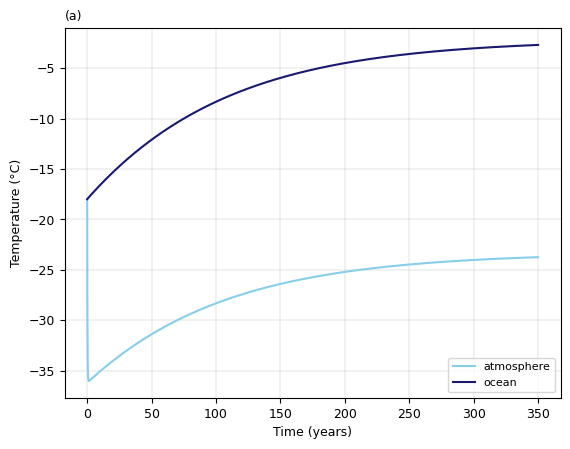

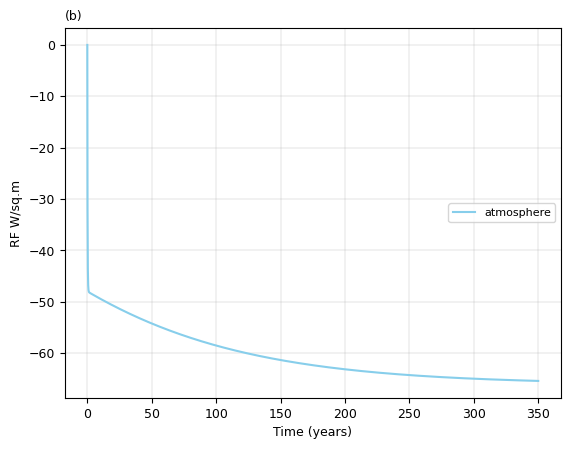

In [9]:
run()